# 회귀로 몸무게 예측하기
* 주어진 데이터를 바탕으로 펭귄 몸무게 예측하기

In [154]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot 을 로드합니다. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')


%matplotlib inline

# 데이터 불러오기

In [155]:
import pandas as pd

# csv 형식으로 된 데이터 파일을 읽어옵니다.
df= pd.read_csv('dataset/train.csv')

# 데이터의 최상단 5 줄을 표시합니다.
df.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [156]:
df.shape

(114, 11)

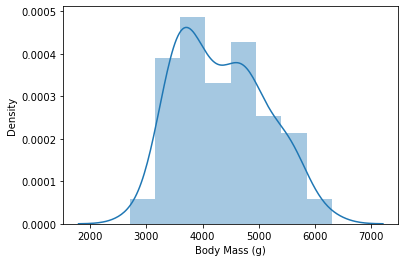

In [157]:
sns.distplot(df["Body Mass (g)"])

In [158]:
df["Body Mass (g)"].describe()

# mean: 4327.850877

count     114.000000
mean     4327.850877
std       781.766484
min      2700.000000
25%      3675.000000
50%      4250.000000
75%      4850.000000
max      6300.000000
Name: Body Mass (g), dtype: float64

# 데이터 전처리


In [159]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_num = sum(dataframe[col].isna())
        is_missing = True if missing_num >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_num}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
            # print(missing_col)
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(df)

결측치가 있는 컬럼은: Sex입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 15 N (o/oo)입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 13 C (o/oo)입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.


## 결측치 처리
* 의미있는 값으로 채우면 분류 예측 결과가 더 좋아집니다. (평균값)

In [132]:
# 결측치를 처리하는 함수를 작성합니다.
def handle_na(data, missing_col):
    temp = data.copy()
    for col, dtype in missing_col:
        print(dtype)
        if dtype == "object": # dtype == 'O':
            # 카테고리형 feature가 결측치인 경우 해당 행들을 삭제해 주었습니다.
            temp = temp.dropna(subset=[col]) 
        elif dtype == "I" or dtype == "float64":# I is integer
            # 수치형 feature가 결측치인 경우 평균값을 채워주었습니다.
            temp.loc[:,col] = temp[col].fillna(temp[col].mean())
    return temp

df_mean = handle_na(df, missing_col)

# # 결측치 처리가 잘 되었는지 확인해 줍니다.
missing_col = check_missing_col(df_mean) 

object
float64
float64
결측치가 존재하지 않습니다


# 학습, 예측에 사용할 컬럼

In [133]:
# # feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
# feature_names = df_mean.columns.tolist()

# feature_names

# # should  ignore 'id' and  'Body Mass (g)'

['id',
 'Species',
 'Island',
 'Clutch Completion',
 'Culmen Length (mm)',
 'Culmen Depth (mm)',
 'Flipper Length (mm)',
 'Sex',
 'Delta 15 N (o/oo)',
 'Delta 13 C (o/oo)',
 'Body Mass (g)']

In [160]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
feature_names = df.columns.tolist()

feature_names

# should  ignore 'id' and  'Body Mass (g)'

['id',
 'Species',
 'Island',
 'Clutch Completion',
 'Culmen Length (mm)',
 'Culmen Depth (mm)',
 'Flipper Length (mm)',
 'Sex',
 'Delta 15 N (o/oo)',
 'Delta 13 C (o/oo)',
 'Body Mass (g)']

In [161]:
# feature_names 에 사용할 컬럼을 담아줍니다.
#  Body Mass (g)는  feature어니고 label입니다
#  # should  ignore 'id' and  'Body Mass (g)'
feature_names = [
 'Species',
 'Island',
 'Clutch Completion',
 'Culmen Length (mm)',
 'Culmen Depth (mm)',
 'Flipper Length (mm)',
 'Sex',
 'Delta 15 N (o/oo)',
 'Delta 13 C (o/oo)']

# 정답값이자 예측해야 될 값

In [162]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.
#  Body Mass (g)는 label입니다
label_name = "Body Mass (g)"
label_name

'Body Mass (g)'

# 학습, 예측 데이터셋 만들기

In [136]:
# X = df_mean[feature_names]
# y = df_mean[label_name]

# X.shape, y.shape

((111, 9), (111,))

In [194]:
X = df[feature_names]
y = df[label_name]

X.shape, y.shape

((114, 9), (114,))

In [137]:
print(df_mean['Species'].unique())
print(df_mean['Island'].unique())
print(df_mean['Sex'].unique())
print(df_mean['Clutch Completion'].unique())

['Gentoo penguin (Pygoscelis papua)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Adelie Penguin (Pygoscelis adeliae)']
['Biscoe' 'Dream' 'Torgersen']
['MALE' 'FEMALE']
['Yes' 'No']


In [13]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder

# ct = ColumnTransformer(
# [("scaling", StandardScaler(), ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']),
#  ("onehot", OneHotEncoder(sparse = False), ['Species', 'Island', 'Clutch Completion', 'Sex'])])

# total 6 feature cols

In [195]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [196]:
# 학습 세트 확인 예) 기출문제(X_train)와 기출문제의 정답(y_train)
print(X_train.shape, y_train.shape)
X_train.head()

(91, 9) (91,)


,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
31,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.2,18.8,197,MALE,9.77528,-24.56481
67,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,49.2,15.2,221,MALE,8.27376,-25.00169
111,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,43.2,18.5,192,MALE,8.97025,-26.03679
108,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,49.0,19.6,212,MALE,9.34089,-24.45189
22,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,43.5,15.2,213,FEMALE,8.21634,-26.11046


In [197]:
# 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제와 실전 시험 문제의 정답

print(X_test.shape, y_test.shape)

(23, 9) (23,)


In [138]:
# print(X.shape, y.shape)
# X.head()

(111, 9) (111,)


,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017
1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684
2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854
3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524
4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272


In [147]:
# # Sex,Clutch Completion 는 male은 1, female은 0, Yes 는 1, No 는 0으로 처리
# X['Sex']=np.where(X['Sex'].values=='MALE',1,np.where(X['Sex'].values=='FEMALE',0,np.nan))
# X['Clutch Completion']=np.where(X['Clutch Completion'].values=='Yes',1,0)
# # Island와 Species는 원 핫 인코딩으로 처리
# train = pd.concat([X,pd.get_dummies(X[['Island','Species']])],axis=1)
# X_train_trans1 = train.drop(['Island','Species'],axis=1)
# X_train_trans1 

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
0,0,50.0,15.3,220,NaN,8.305150,-25.190170,1,0,0,0,0,1
1,0,49.5,19.0,200,NaN,9.630740,-24.346840,0,1,0,0,1,0
2,0,45.1,14.4,210,NaN,8.519510,-27.018540,1,0,0,0,0,1
3,0,44.5,14.7,214,NaN,8.201060,-26.165240,1,0,0,0,0,1
4,0,49.6,16.0,225,NaN,8.383240,-26.842720,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0,36.6,17.8,185,NaN,8.738543,-25.718804,0,0,1,1,0,0
110,0,39.2,18.6,190,NaN,9.110060,-25.795490,0,1,0,1,0,0
111,0,43.2,18.5,192,NaN,8.970250,-26.036790,0,1,0,1,0,0
112,0,46.9,16.6,192,NaN,9.805890,-24.737350,0,1,0,0,1,0


In [199]:
# Sex,Clutch Completion 는 male은 1, female은 0, Yes 는 1, No 는 0으로 처리
X_train['Sex']=np.where(X_train['Sex'].values=='MALE',1,np.where(X_train['Sex'].values=='FEMALE',0,np.nan))
X_train['Clutch Completion']=np.where(X_train['Clutch Completion'].values=='Yes',1,0)
# Island와 Species는 원 핫 인코딩으로 처리
train = pd.concat([X_train,pd.get_dummies(X_train[['Island','Species']])],axis=1)
X_train_trans1 = train.drop(['Island','Species'],axis=1)
X_train_trans1 

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
31,1,52.2,18.8,197,1.0,9.77528,-24.56481,0,1,0,0,1,0
67,1,49.2,15.2,221,1.0,8.27376,-25.00169,1,0,0,0,0,1
111,1,43.2,18.5,192,1.0,8.97025,-26.03679,0,1,0,1,0,0
108,1,49.0,19.6,212,1.0,9.34089,-24.45189,0,1,0,0,1,0
22,1,43.5,15.2,213,0.0,8.21634,-26.11046,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1,45.5,15.0,220,1.0,8.63604,-26.74890,1,0,0,0,0,1
14,1,41.1,18.2,192,1.0,8.62264,-26.60023,1,0,0,1,0,0
92,1,45.2,14.8,212,0.0,8.24246,-26.11969,1,0,0,0,0,1
51,0,43.5,18.1,202,0.0,9.37608,-24.40753,0,1,0,0,1,0


In [15]:
# # ColumnTransformer로 생성된 객체 적용
# ct.fit(X)
# X_train_trans = ct.transform(X)

# # 결과 확인
# print(X_train_trans.shape)
# pd.DataFrame(X_train_trans)

(111, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.003013,-0.887034,1.148185,-7.712702e-01,6.237650e-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.908083,1.043569,-0.215630,1.587759e+00,1.618858e+00,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.072695,-1.356640,0.466277,-3.897936e-01,-1.533633e+00,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.041222,-1.200104,0.739040,-9.565095e-01,-5.267759e-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.927069,-0.521784,1.489138,-6.323006e-01,-1.326173e+00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-1.541124,0.417428,-1.238491,-3.161217e-15,1.676820e-14,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
107,-1.047485,0.834855,-0.897538,6.611535e-01,-9.048670e-02,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
108,-0.288041,0.782677,-0.761156,4.123466e-01,-3.752104e-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
109,0.414444,-0.208714,-0.761156,1.899458e+00,1.158073e+00,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [200]:
missing_col_X_train_trans1= check_missing_col(X_train_trans1)

결측치가 있는 컬럼은: Sex입니다
해당 컬럼에 총 2개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 15 N (o/oo)입니다
해당 컬럼에 총 2개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 13 C (o/oo)입니다
해당 컬럼에 총 2개의 결측치가 존재합니다.


In [201]:
np.where(X_train_trans1['Delta 13 C (o/oo)'].isnull()==True)

(array([35, 64], dtype=int64),)

In [202]:
X_train_trans1['Delta 13 C (o/oo)'].iloc[np.where(X_train_trans1['Delta 13 C (o/oo)'].isnull()==True)] = [ 0, 0]
X_train_trans1['Delta 15 N (o/oo)'].iloc[np.where(X_train_trans1['Delta 15 N (o/oo)'].isnull()==True)] = [ 0, 0]
# assume all the NaN value in "Sex" is FEMALE, 0
X_train_trans1['Sex'].iloc[np.where(X_train_trans1['Sex'].isnull()==True)] = [ 0, 0]

In [203]:
missing_col_X_train_trans1 = check_missing_col(X_train_trans1)

결측치가 존재하지 않습니다


# 머신러닝 알고리즘 가져오기
1. 의사결정나무 사용하기
1. 랜덤포레스트 사용하기
1. 그라디언트 부스팅 사용하기

## 사용할 알고리즘을 리스트 형태로 만들기
- estimators라는 변수에 DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor를 리스트로 할당해 줍니다.

In [204]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  

estimators = [
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]
estimators

[DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 GradientBoostingRegressor(random_state=42)]

In [205]:
# 랜덤서치를 구현하기 전에 for문을 통해 여러 개의 모델을 순회하는 반복문을 구현해 봅니다. 
# result 에는 각 모델의 결과값을 저장하고
# results 에 각 모델에서 나온 result 값을 모아줍니다.

results = []
for estimator in estimators:
    result = []
    result.append(estimator.__class__.__name__)
    results.append(result)

# 데이터 프레임 형태로 변환해 보면 모델별 결과값을 데이터프레임에 추가해서 보면 값을 비교해 볼 수 있을거 같습니다.
pd.DataFrame(results)
#create a table to tabulate the performance of the model's estimators

,0
0,DecisionTreeRegressor
1,RandomForestRegressor
2,GradientBoostingRegressor


##  랜덤한 파라메터 값 리스트로 구현하기
* RandomizedSearchCV 에 사용할 param_distributions 값을 만들어 주세요.
* max_depth 값을 int 형식으로 랜덤하게 10개의 원소를 갖는 리스트 형태로 만들어 주세요.
* max_features 값을 float 형식으로 랜덤하게 10개의 원소를 갖는 리스트 형태로 만들어 주세요.

In [150]:
# 예
np.random.randint(10,30, 15)

#randomly create 15 numbers ranged from 10 to 30
#randint >> random integer

array([11, 14, 23, 21, 21, 24, 11, 27, 15, 22, 24, 11, 12, 12, 18])

In [151]:
# 예
np.random.uniform(0.5,1.0, 10)

#use loop to create random number with gaussian distribution ranged from 0.5 to 1.0

array([0.66666019, 0.7849025 , 0.82450472, 0.84955244, 0.82097096,
       0.79740513, 0.59481782, 0.62318572, 0.9983211 , 0.52794855])

In [206]:
def make_params_Regression():

    max_depth = np.random.randint(10, 30, 10) # using the number created randomly, and set as max_depth's value
    max_features = np.random.uniform(0.5, 1.0, 10) #same, but is based on gaussian distribution

    param_distributions = {"max_depth": max_depth, "max_features": max_features }

    return param_distributions

# 구현한 함수의 결과 값을 param_distributions 변수에 할당합니다.
param_distributions = make_params_Regression()
param_distributions

{'max_depth': array([26, 23, 28, 26, 12, 19, 16, 18, 26, 10]),
 'max_features': array([0.58589868, 0.93052106, 0.7481322 , 0.86377287, 0.79949166,
        0.65912027, 0.73819598, 0.5129556 , 0.69863738, 0.54591013])}

## RandomizedSearchCV 구현하기
* RandomizedSearchCV 를 정의하기. (cv값은 3개)
* cv값은 3개 이상으로 구현하면 조각이 너무 많아서 오래 걸릴 수 있습니다. 
* cv값을 3개로 구현했을 때 너무 오래 걸리지 않는다면 조각의 수를 늘려주셔도 됩니다.
* n_iter를 5로 설정하고 cv를 3으로 설정하면 하나의 모델을 학습할 때 15번의 fit을 하게 됩니다.
* n_iter의 값을 많이 설정할 수록 더 많은 파라메터를 테스트할 수 있습니다.
* 또, n_iter의 값을 더 크게 설정한다면 파라메터의 갯수도 그 만큼 늘려주어야 많은 파라메터 중 성능이 좋은 파라메터를 찾을 수 있습니다.

In [207]:
# RandomizedSearchCV 를 통해 위에서 정의한 모델과 해당 모델의 최적의 파라메터값을 찾아봅니다.
# 시간이 너무 오래 걸린다면 google colaboratory 를 통해 실습하시는 것을 권장드립니다.

from sklearn.model_selection import RandomizedSearchCV

results = []
for estimator in estimators:
    result = []

    param_distributions = make_params_Regression()

    regressor = RandomizedSearchCV(estimator,
        param_distributions,
        n_iter=8, # 5
        scoring=None,
        n_jobs=-1,
        cv=4, # 3이상, 다른 값해 봐도 됩니다
        verbose=1, 
        random_state=42)

    regressor.fit(X_train_trans1, y_train)
    
    result.append(estimator.__class__.__name__)
    result.append(regressor.best_params_)
    result.append(regressor.best_estimator_)
    result.append(regressor.best_score_)
    result.append(regressor.cv_results_)
    results.append(result)

#RandomizedSearchCV just saying we randomly pick sample to do cross validation
#10-fold Crossvalidation is do 10 times cross validation
#adjust cv to adjust how much cross validation we want
#cv is one of the sampling, see evernote seach cross validation
# was 15 fits

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


## 결과를 데이터프레임 형태로 만들기

In [208]:
df_cv = pd.DataFrame(results)
df_cv.columns = ["model", "params", "estimator", "score", "cv_result"]
df_cv = df_cv.sort_values("score", ascending=False)
df_cv

#the best estimator is placed at index=0  which is random forest regressor
# 0.820234

,model,params,estimator,score,cv_result
1,RandomForestRegressor,"{'max_features': 0.726572705015234, 'max_depth...","(DecisionTreeRegressor(max_depth=13, max_featu...",0.656261,"{'mean_fit_time': [0.1454008102416992, 0.15420..."
2,GradientBoostingRegressor,"{'max_features': 0.6336383303117834, 'max_dept...",([DecisionTreeRegressor(criterion='friedman_ms...,0.566270,"{'mean_fit_time': [0.043000650405883786, 0.043..."
0,DecisionTreeRegressor,"{'max_features': 0.8739134653806597, 'max_dept...","DecisionTreeRegressor(max_depth=23, max_featur...",0.366432,"{'mean_fit_time': [0.00319974422454834, 0.0026..."


## 가장 좋은 성능을 내는 estimator 찾기

In [209]:
best_estimator = df_cv.iloc[0]["estimator"]
best_estimator

#from previous line, best estimator is at index = 0

RandomForestRegressor(max_depth=13, max_features=0.726572705015234,
                      random_state=42)

In [210]:
pd.DataFrame(df_cv.iloc[0]["cv_result"])

#mean_test_score is the mean of score of each cross validation (every split of the data to train and test de set)
#from rank_test_score, we see that param_max_depth=19, can get high score (we want good result in test!)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.145401,0.010022,0.0119,0.002343,0.88148,25,"{'max_features': 0.8814799697842526, 'max_dept...",0.572318,0.896690,-0.287246,0.867685,0.792839,0.789427,0.905818,0.787438,0.193000,0.888776,0.640675,0.371736,4
1,0.154200,0.010600,0.0135,0.002907,0.88148,18,"{'max_features': 0.8814799697842526, 'max_dept...",0.572318,0.896690,-0.287246,0.867685,0.792839,0.789427,0.905818,0.787438,0.193000,0.888776,0.640675,0.371736,4
2,0.146400,0.010707,0.0129,0.002468,0.791177,23,"{'max_features': 0.7911767015989821, 'max_dept...",0.615922,0.916605,-0.247161,0.872799,0.793564,0.814180,0.902656,0.784483,0.189803,0.891163,0.653402,0.364155,2
3,0.142300,0.005900,0.0096,0.001200,0.85425,13,"{'max_features': 0.8542495408114923, 'max_dept...",0.572289,0.896690,-0.287246,0.868223,0.792839,0.789427,0.905818,0.787438,0.195216,0.888851,0.640954,0.371508,3
4,0.125999,0.016365,0.0076,0.001908,0.726573,13,"{'max_features': 0.726572705015234, 'max_depth...",0.634727,0.918171,-0.296261,0.852143,0.803815,0.822978,0.895711,0.790508,0.246056,0.894766,0.656261,0.369433,1


# 학습(훈련)
* (X_train)와 정답(y_train)을 활용하고 학습하는 과정

In [211]:
best_estimator.fit(X_train_trans1, y_train)

# max_features=0.6684454463573148
# now, max_features=0.726572705015234

RandomForestRegressor(max_depth=13, max_features=0.726572705015234,
                      random_state=42)

# cross validation 으로 학습 세트의 오차 측정하기

In [212]:
# train set와 valid set를 나눠 cross validation으로 train set으로 학습한 모델을 검증합니다.
# cv=5 , 5 cross validation
# test 점수를 예측하기 전에 
from sklearn.model_selection import cross_val_predict

y_valid_predict = cross_val_predict(best_estimator,X_train_trans1, y_train, cv=5, verbose=1, n_jobs=-1)
y_valid_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


array([4032.5, 4901. , 4053.5, 4466.5, 4975. ])

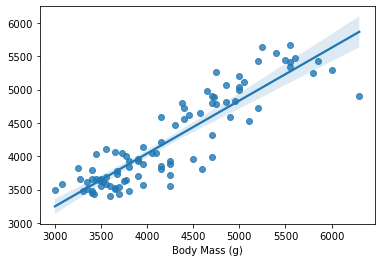

In [213]:
# regplot 으로 결과 값을 비교합니다.
# 회귀선에서 멀리 떨어질 수록 실제값과 예측값의 차이가 많이 납니다.
# 회귀선에 가까울수록 실제값과 예측값의 차이가 작습니다.
sns.regplot(y_train, y_valid_predict)

In [214]:
# r2_score 를 구합니다. 1에 가까울 수록 정확도가 높습니다.
# 0.75 이상의 값이 나오는지 확인합니다.

from sklearn.metrics import r2_score

r2_score(y_train, y_valid_predict)

# r2 score is the correlation score
# if get 1.0 is the best, means the closest 
# 0.8171223314134943
# now, 0.7964199546886309

0.7964199546886309

## 정확도(MAE) 측정하기

In [215]:
mae = abs(y_train - y_valid_predict).mean()
mae

# 264.85135135135135
# now, 261.3379120879121

261.3379120879121

# RMSE

In [217]:
# 대회 규칙의 평가 산식 함수를 그대로 사용합니다.
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

In [219]:
# 실제 정답 값을 준비합니다.
real_answer = y_train.copy() # change here

# 정답과 예측 값을 함수에 넣어 결과를 확인합니다.
error = RMSE(real_answer, y_valid_predict)

print(f"이 방정식의 평균 에러는 {error:.2f} 입니다.")
# 344.19
# npw, 344.61

이 방정식의 평균 에러는 344.61 입니다.


In [220]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_train,  y_valid_predict)
rmse = np.sqrt(mse)
rmse
# 335.25559363426447
# now, 344.6141445934078

344.6141445934078

# 예측값과 실제값 비교하기

In [222]:
pd.DataFrame({"test" : y_train, 
              "predict" : y_valid_predict,
              "error" : abs(y_train-y_valid_predict)
             }).head()

#create a df to tabulate test, predict and error
#if error get 0, perfect score laa 

,test,predict,error
31,3450,4032.5,582.5
67,6300,4901.0,1399.0
111,4100,4053.5,46.5
108,4300,4466.5,166.5
22,4650,4975.0,325.0


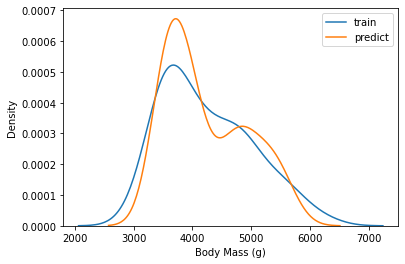

In [223]:
# distplot으로 정답값과 예측값의 분포를 그립니다.

sns.distplot(y_train, hist=False, label="train")
sns.distplot(y_valid_predict, hist=False, label="predict")

plt.legend()
plt.show()

# test_data 예측하기

In [224]:
# 우리가 예측하고자 하는 test 데이터를 불러옵니다.
df_test = pd.read_csv('dataset/test.csv').drop(['id'],axis=1)

df_test.head()

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [226]:
# Sex,Clutch Completion 는 male은 1, female은 0, Yes 는 1, No 는 0으로 처리
df_test['Sex']=np.where(df_test['Sex'].values=='MALE',1,np.where(df_test['Sex'].values=='FEMALE',0,np.nan))
df_test['Clutch Completion']=np.where(df_test['Clutch Completion'].values=='Yes',1,0)
# Island와 Species는 원 핫 인코딩으로 처리
test = pd.concat([df_test,pd.get_dummies(df_test[['Island','Species']])],axis=1)
X_test_trans1 = test.drop(['Island','Species'],axis=1)
X_test_trans1

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
0,1,52.0,20.7,210.0,1.0,9.43146,-24.68440,0,1,0,0,1,0
1,1,55.9,17.0,228.0,1.0,8.31180,-26.35425,1,0,0,0,0,1
2,1,38.9,18.8,190.0,0.0,8.36936,-26.11199,0,1,0,1,0,0
3,1,45.2,16.6,191.0,0.0,9.62357,-24.78984,0,1,0,0,1,0
4,0,37.9,18.6,172.0,0.0,8.38404,-25.19837,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,1,49.3,19.9,203.0,1.0,9.88809,-24.59513,0,1,0,0,1,0
224,1,46.5,14.8,217.0,0.0,8.58487,-26.59290,1,0,0,0,0,1
225,1,46.5,13.5,210.0,0.0,7.99530,-25.32829,1,0,0,0,0,1
226,1,50.5,19.6,201.0,1.0,9.80590,-24.72940,0,1,0,0,1,0


In [56]:
# # cannot control df_test
# df_test_mean = handle_na(df_test, missing_col_test)

# # # 결측치 처리가 잘 되었는지 확인해 줍니다.
# missing_col = check_missing_col(df_test_mean) 

object
float64
float64
결측치가 존재하지 않습니다


In [57]:
# cannot control df_test
# X_test = df_test_mean[feature_names]
# X_test.head()

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [58]:
# # cannot control df_test
# # ct.fit(X_test)
# # X_test_trans = ct.transform(X_test)

# X_test_trans1 = pd.get_dummies(X_test)
# # 결과 확인
# print(X_test_trans1.shape)
# pd.DataFrame(X_test_trans1)

(222, 15)


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua),Island_Biscoe,Island_Dream,Island_Torgersen,Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,52.0,20.7,210.0,9.43146,-24.68440,0,1,0,0,1,0,0,1,0,1
1,55.9,17.0,228.0,8.31180,-26.35425,0,0,1,1,0,0,0,1,0,1
2,38.9,18.8,190.0,8.36936,-26.11199,1,0,0,0,1,0,0,1,1,0
3,45.2,16.6,191.0,9.62357,-24.78984,0,1,0,0,1,0,0,1,1,0
4,37.9,18.6,172.0,8.38404,-25.19837,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,49.3,19.9,203.0,9.88809,-24.59513,0,1,0,0,1,0,0,1,0,1
224,46.5,14.8,217.0,8.58487,-26.59290,0,0,1,1,0,0,0,1,1,0
225,46.5,13.5,210.0,7.99530,-25.32829,0,0,1,1,0,0,0,1,1,0
226,50.5,19.6,201.0,9.80590,-24.72940,0,1,0,0,1,0,0,1,0,1


In [81]:
# X_test_trans1 = pd.get_dummies(df_test)
# # 결과 확인
# print(X_test_trans1.shape)
# pd.DataFrame(X_test_trans1)

(228, 16)


,id,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua),Island_Biscoe,Island_Dream,Island_Torgersen,Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,0,52.0,20.7,210.0,9.43146,-24.68440,0,1,0,0,1,0,0,1,0,1
1,1,55.9,17.0,228.0,8.31180,-26.35425,0,0,1,1,0,0,0,1,0,1
2,2,38.9,18.8,190.0,8.36936,-26.11199,1,0,0,0,1,0,0,1,1,0
3,3,45.2,16.6,191.0,9.62357,-24.78984,0,1,0,0,1,0,0,1,1,0
4,4,37.9,18.6,172.0,8.38404,-25.19837,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,223,49.3,19.9,203.0,9.88809,-24.59513,0,1,0,0,1,0,0,1,0,1
224,224,46.5,14.8,217.0,8.58487,-26.59290,0,0,1,1,0,0,0,1,1,0
225,225,46.5,13.5,210.0,7.99530,-25.32829,0,0,1,1,0,0,0,1,1,0
226,226,50.5,19.6,201.0,9.80590,-24.72940,0,1,0,0,1,0,0,1,0,1


In [227]:
missing_col_test = check_missing_col(X_test_trans1)

결측치가 있는 컬럼은: Sex입니다
해당 컬럼에 총 6개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 15 N (o/oo)입니다
해당 컬럼에 총 9개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 13 C (o/oo)입니다
해당 컬럼에 총 8개의 결측치가 존재합니다.


In [109]:
np.where(X_test_trans1['Delta 13 C (o/oo)'].isnull()==True) 

(array([ 27,  81, 106, 159, 175, 202, 205, 215], dtype=int64),)

In [110]:
np.where(X_test_trans1['Delta 15 N (o/oo)'].isnull()==True)

(array([ 27,  75,  81, 106, 159, 175, 202, 205, 215], dtype=int64),)

In [111]:
np.where(X_test_trans1['Sex'].isnull()==True)

(array([ 46,  81,  98, 152, 205, 209], dtype=int64),)

In [228]:
X_test_trans1['Delta 13 C (o/oo)'].iloc[np.where(X_test_trans1['Delta 13 C (o/oo)'].isnull()==True)] = [ 0, 0, 0, 0, 0, 0, 0, 0]
X_test_trans1['Delta 15 N (o/oo)'].iloc[np.where(X_test_trans1['Delta 15 N (o/oo)'].isnull()==True)] = [ 0, 0, 0, 0, 0, 0, 0, 0, 0]
# assume all the NaN value in "Sex" is FEMALE, 0
X_test_trans1['Sex'].iloc[np.where(X_test_trans1['Sex'].isnull()==True)] = [ 0, 0, 0, 0, 0, 0]



In [229]:
missing_col_test = check_missing_col(X_test_trans1)

결측치가 존재하지 않습니다


In [233]:
# 위에서 찾은 best_estimator 를 통해 실제값을 예측합니다.
y_predict = best_estimator.predict(X_test_trans1)
y_predict[:5]

#y_pred = model.predict(X_test) >> this is what did b4
#this time choose the best_estimator dulu

array([4127.75, 5531.5 , 3542.75, 3552.  , 3445.  ])

In [234]:
y_predict

array([4127.75, 5531.5 , 3542.75, 3552.  , 3445.  , 3958.  , 4668.  ,
       4790.  , 4732.25, 3839.5 , 3994.75, 4642.  , 4831.5 , 4820.  ,
       4893.  , 4883.5 , 3844.75, 3936.  , 3525.  , 3535.75, 4006.  ,
       5546.  , 5322.  , 3954.75, 3615.5 , 4599.5 , 3536.75, 4023.75,
       4008.25, 4511.75, 3608.5 , 4807.5 , 3550.5 , 5000.75, 3966.25,
       3366.75, 4379.75, 3549.75, 3882.25, 4564.75, 3927.75, 3567.75,
       4051.  , 5493.75, 3511.  , 4535.  , 3428.75, 4012.5 , 4772.25,
       5562.5 , 3564.  , 3922.75, 3455.25, 3898.5 , 4018.5 , 3888.  ,
       4540.75, 3921.75, 4765.25, 3654.  , 3813.25, 3538.5 , 3940.25,
       5724.5 , 3453.25, 3994.75, 4085.  , 4579.  , 3892.  , 3942.25,
       4753.  , 3234.25, 3436.25, 3590.5 , 5299.5 , 4363.25, 3420.25,
       3769.75, 5376.5 , 4526.  , 3985.5 , 3601.25, 4155.25, 4498.75,
       5058.5 , 3978.  , 4987.25, 3915.25, 3474.5 , 5252.25, 4637.5 ,
       3546.  , 3475.25, 3684.75, 3467.75, 3522.75, 3480.25, 3446.  ,
       4757.5 , 3945

In [235]:
# convert array to dataframe
pd.DataFrame(y_predict)

,0
0,4127.75
1,5531.50
2,3542.75
3,3552.00
4,3445.00
...,...
223,3890.75
224,4801.75
225,4426.25
226,3844.75


# 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.

In [230]:
# 피처의 중요도를 추출하기
feature_importance = best_estimator.feature_importances_
feature_importance

#model >> best_estimator

array([0.00210933, 0.05220858, 0.0827704 , 0.33391755, 0.05733219,
       0.02286395, 0.03671475, 0.01537368, 0.00263184, 0.00210977,
       0.00301686, 0.00118238, 0.38776873])

## 피처의 중요도 시각화

In [231]:
one_hot_features = X_train_trans1.columns
one_hot_features

Index(['Clutch Completion', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
       'Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)'],
      dtype='object')

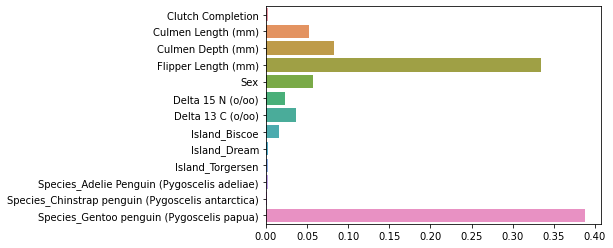

In [232]:
# 피처의 중요도 시각화 하기
sns.barplot(x=feature_importance, y=one_hot_features)

From here, we can see 'Flipper Length (mm)', 'Species_Gentoo penguin (Pygoscelis papua)', influence the prediction the most

# dacon 대회에 제출하기

이제 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [236]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv('dataset/sample_submission.csv')
submission.head()

,id,Body Mass (g)
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [237]:
submission.shape

(228, 2)

In [238]:
y_predict.shape

(228,)

In [239]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['Body Mass (g)'] = y_predict

# 데이터가 잘 들어갔는지 확인합니다.
submission

,id,Body Mass (g)
0,0,4127.75
1,1,5531.50
2,2,3542.75
3,3,3552.00
4,4,3445.00
...,...,...
223,223,3890.75
224,224,4801.75
225,225,4426.25
226,226,3844.75


In [240]:
submission.to_csv("./result/submission_20220103_v1.csv", index=False)